## Run experiment to synthesize dataset without labelled nodes
This notebook compares run the experiment to synthesize a dataset. The synthesied dataset don't have labels therefore the performance is only measured on 'intrinsic' graph properties. The experiment consists of the following steps and is performed 10 time to account for stochasticity

- train and calculate the graphsage embedding
- train DDPM network and create synthetic nodes.
- for the LSTM, MLP and bi-MLP vairants:
    - train model and create synthetic edges.
    - create synthetic graph
    - measure performance
    - copy relevant data (synthetic graph, embedding to experiment folder)
    - save performance.

In [1]:
# Set root dir
import os
os.chdir('..')
print(os.getcwd())

/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj


In [2]:
# import modules
import pickle
import pathlib
from tigger_package.orchestrator import Orchestrator
from tigger_package.metrics.distribution_metrics import compare_metrics
from tigger_package.tools import plot_adj_matrix, plot_hist
from datetime import datetime, date
import networkx as nx 
import pandas as pd
import time
import glob


loaded


In [3]:
def copy_data(folder, variant_name, run_nr):
    path = pathlib.Path(folder + "exp_results/no_labels")
    path.mkdir(parents=True, exist_ok=True)
    #copy synthetic nodes
    tmp = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
    tmp.to_parquet(folder + f'exp_results/no_labels/node_attributes_{variant_name}_run_{run_nr}.parquet')
    # copy synthetic edges of synth graph
    tmp = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
    tmp.to_parquet(folder + f'exp_results/no_labels/adjacency_{variant_name}_run_{run_nr}.parquet')
    # copy synthetic walks
    obj = pickle.load(open(folder + 'synth_walks.pickle', 'rb'))
    pickle.dump(obj, open(folder + f'exp_results/no_labels/synth_walks_{variant_name}_run_{run_nr}.pickle', 'wb'))
    
def measure_performance(orchestrator, variant_name):
    nodes = orchestrator._load_nodes()
    edges = orchestrator._load_edges()
    lstm_nodes = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
    lstm_edges = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
    res = compare_metrics(nodes, edges, lstm_nodes, lstm_edges, variant_name)
    return res

def run_single_experiment(run_nr, folder):
    # create synthetic nodes and embedding
    orchestrator = Orchestrator(folder)
    nodes_sampled = 0
    while nodes_sampled == 0:
        orchestrator.create_graphsage_embedding()
        orchestrator.train_node_synthesizer()
        orchestrator.sample_node_synthesizer()
        nodes_sampled = orchestrator._load_synthetic_nodes().shape[0]

    res = []
    for variant_name in ['LSTM', 'MLP', 'Bi-MLP']:
        #train variant and sample edges
        target_cnt = 2 * orchestrator._load_edges().shape[0]
        orchestrator.init_graphsynthesizer(variant_name, seed=run_nr)
        orchestrator.train_graphsyntesizer()
        orchestrator.create_synthetic_walks(
            synthesizer=orchestrator.graphsynthesizer, 
            target_cnt=target_cnt
        )
               
        # create synth graph
        orchestrator.generate_synth_graph()

        #copy relevant data
        copy_data(folder, variant_name, run_nr)
        
        # measure performance
        res.append(measure_performance(orchestrator, variant_name))
        
    res = (res[0]
           .merge(res[1], on=['name', 'type', 'metric'])
           .merge(res[2], on=['name', 'type', 'metric'])
    )
    res['run_id'] = run_nr
    res['run_tijd'] = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    return res[['name', 'type', 'metric', 'LSTM', 'MLP', 'Bi-MLP','run_id', 'run_tijd']]
  
def  init_res_dataset(folder):
    matching_files = glob.glob(folder + f"exp_results/no_labels/combined_raw_results_*")
    if len(matching_files)> 0:
        max_date = max([int(f.split(".")[0][-8:]) for f in matching_files])
        res_path = f"{folder}exp_results/no_labels/combined_raw_results_{max_date}.parquet"
        res = [pd.read_parquet(res_path)]
        start_run = res[0]['run_id'].max() + 1
    else:
        res = []
        start_run = 0
    return start_run, res

def run_experiment(folder, runs=10):
    start_run, res = init_res_dataset(folder)
    for run_nr in range(start_run, start_run + runs):
        print(f"start processing run {run_nr}")
        res.append(run_single_experiment(run_nr, folder))  
        total_df = pd.concat(res, axis=0)
        date_str = date.today().strftime("%Y%m%d")
        total_df.to_parquet(folder + f"exp_results/no_labels/combined_raw_results_{date_str}.parquet")
    return total_df  

def calculate_Stats(res):
    node_attributes = res[res['type']=='node_attributes'].groupby('run_id').agg({'LSTM': 'mean', 'MLP': 'mean', 'Bi-MLP': 'mean', 'type': 'max'}).reset_index()
    edge_attributes = res[res['type']=='edge_attributes'].groupby('run_id').agg({'LSTM': 'mean', 'MLP': 'mean', 'Bi-MLP': 'mean', 'type': 'max'}).reset_index()
    dif_cluster_coef = res[res['name']=='dif_cluster_coef'][['name', 'LSTM', 'MLP', 'Bi-MLP', 'run_id'] ].rename(columns={'name': 'type'})
    delta_widget = res[res['name']=='mean_delta_widget'][['name', 'LSTM', 'MLP', 'Bi-MLP', 'run_id'] ].rename(columns={'name': 'type'})
    edge_cnt = (res[(res['type']=='edge_cnt') & (res['name']=='edge_count')].set_index('run_id')[['LSTM', 'MLP', 'Bi-MLP']] -  
                res[(res['type']=='edge_cnt') & (res['name']=='orig_edge_count')].set_index('run_id')[['LSTM', 'MLP', 'Bi-MLP']]
    )
    edge_cnt['type'] = "Delta_edge_count"
    edge_cnt = edge_cnt.reset_index(names='run_id')
    cluster_coef = res[res['name'].str.startswith('dif_')][['name', 'LSTM', 'MLP', 'Bi-MLP', 'run_id'] ].rename(columns={'name': 'type'})
    sum_res = pd.concat([node_attributes, edge_attributes, dif_cluster_coef, delta_widget, edge_cnt, cluster_coef], axis=0)
    sum_stat = sum_res.groupby('type').mean()
    return sum_stat      

# ERDOS

start processing run 3
Epoch: 1603, Loss: 0.5972,  Test: 0.5896Early stopping after 1604 epochs with no improvement in validation loss.
Total training time 200.1112s


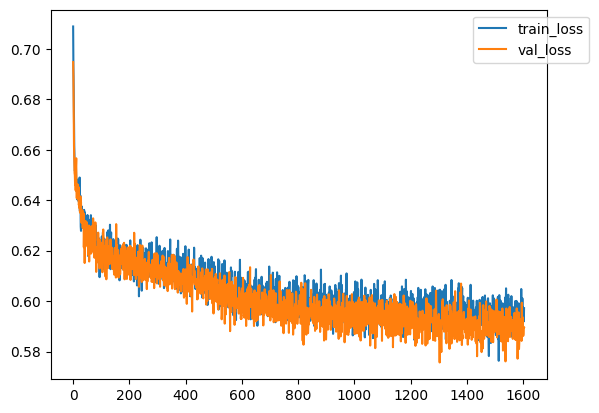

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 0.0892 Sum: 0.0892 val:0.0360
there are 150 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=0.890582799911499, val_loss: 0.92884555459022522

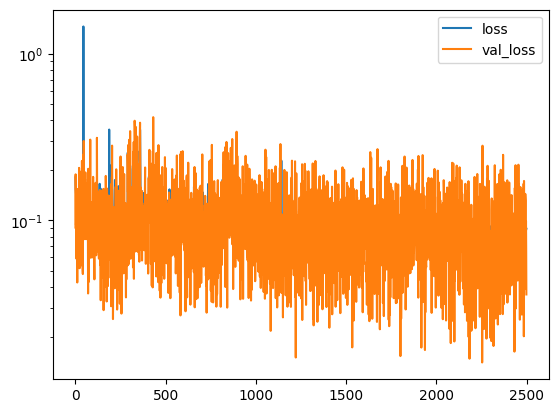

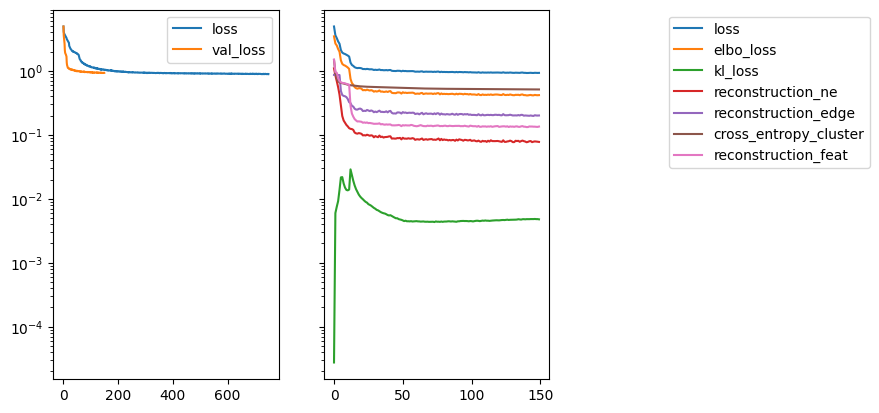

 epoch 775/775 train loss 1.1160 val loss: 1.1951

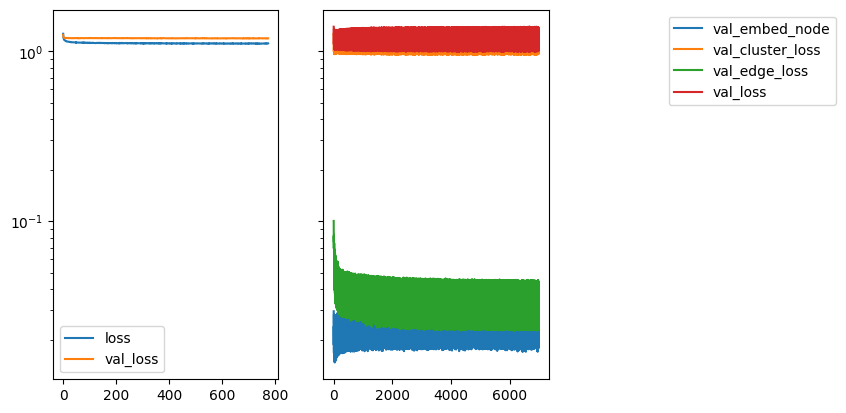

 epoch 375/375 train loss 1.2796 val loss: 1.1610start processing run 4
Epoch: 1583, Loss: 0.6001,  Test: 0.5897Early stopping after 1584 epochs with no improvement in validation loss.
Total training time 192.8977s


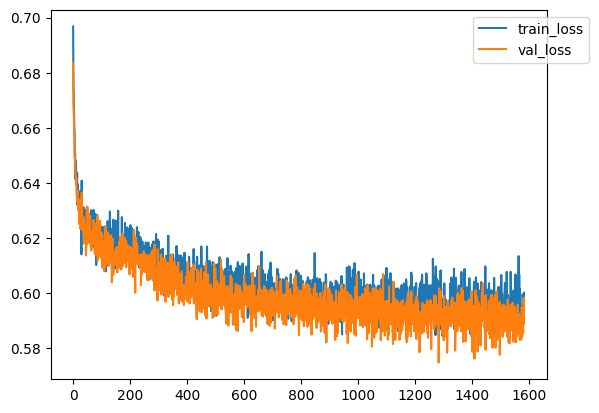

Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 324 out of 300 = 108.0oss: 1.0016 Sum: 1.0016 val:1.0989
there are 0 nodes sampled
Epoch: 000, Loss: 0.7279,  Test: 0.6871

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Epoch: 2481, Loss: 0.5798,  Test: 0.5837Early stopping after 2482 epochs with no improvement in validation loss.
Total training time 302.2325s


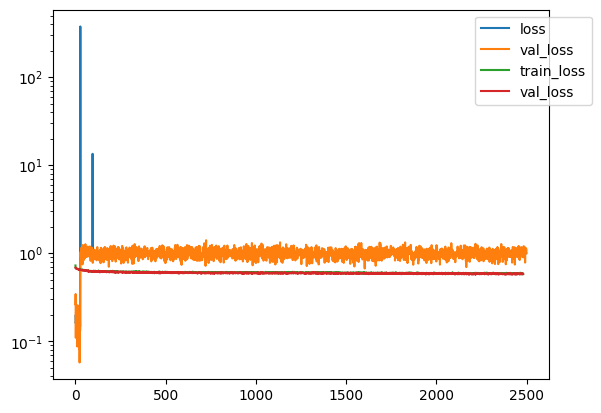

Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03, 'd_in': 128, 'd_out': 13}, 'd_in': 13, 'num_classes': 13}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 324 out of 300 = 108.0oss: 0.9958 Sum: 0.9958 val:0.860123
there are 0 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Epoch: 2610, Loss: 0.5822,  Test: 0.5935Early stopping after 2611 epochs with no improvement in validation loss.
Total training time 337.3058s


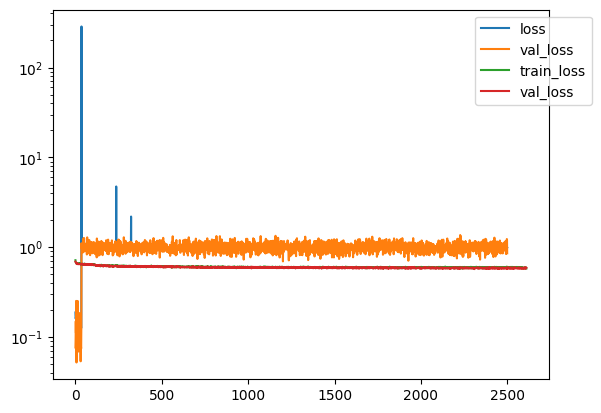

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03, 'd_in': 128, 'd_out': 13}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 1.0043 Sum: 1.0043 val:0.842244
there are 0 nodes sampled
Epoch: 000, Loss: 0.7028,  Test: 0.6866

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Epoch: 1945, Loss: 0.5748,  Test: 0.5877Early stopping after 1946 epochs with no improvement in validation loss.
Total training time 243.0849s


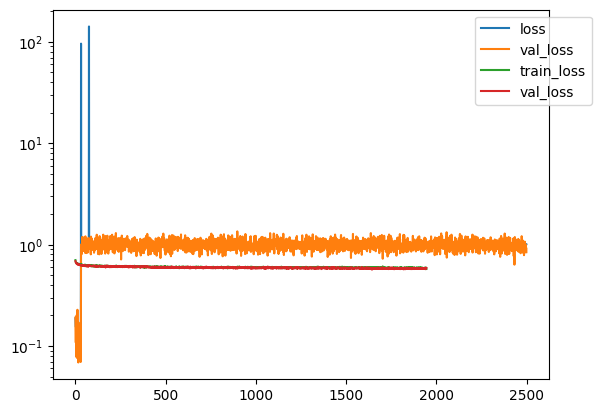

Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03, 'd_in': 128, 'd_out': 13}, 'd_in': 13, 'num_classes': 13}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 324 out of 300 = 108.0oss: 0.1139 Sum: 0.1139 val:0.0936
there are 150 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=1.058374285697937, val_loss: 1.12007242441177377

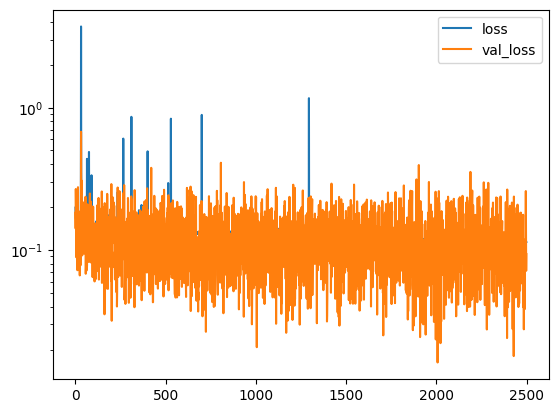

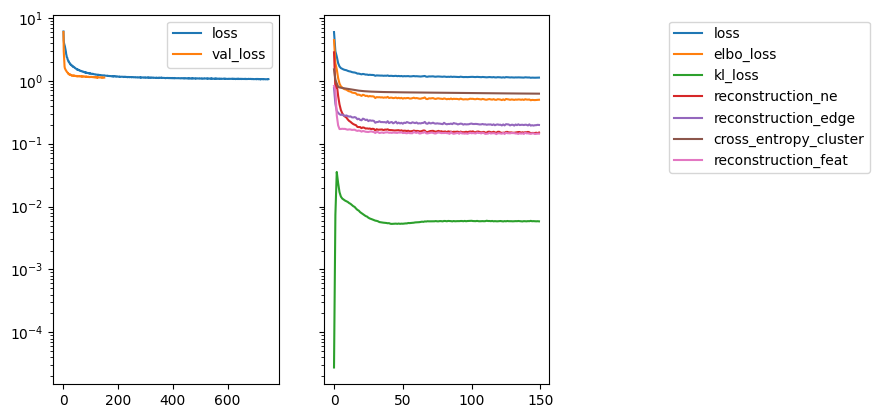

 epoch 775/775 train loss 0.8331 val loss: 0.8812

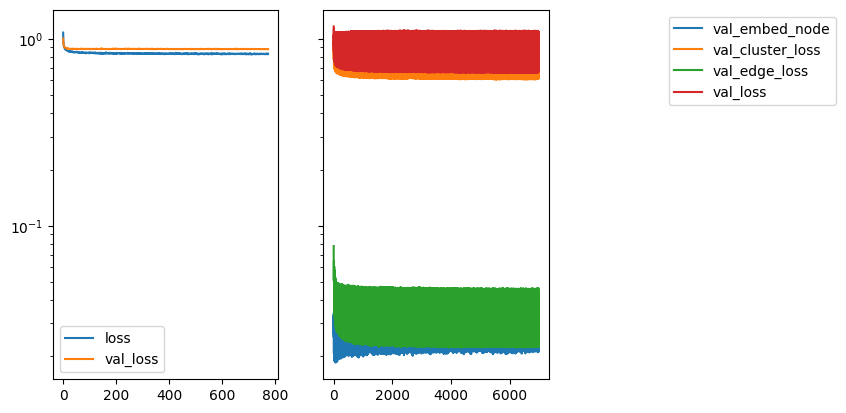

 epoch 375/375 train loss 1.4422 val loss: 1.4159start processing run 5
Epoch: 814, Loss: 0.6186,  Test: 0.6106Early stopping after 815 epochs with no improvement in validation loss.
Total training time 98.4824s


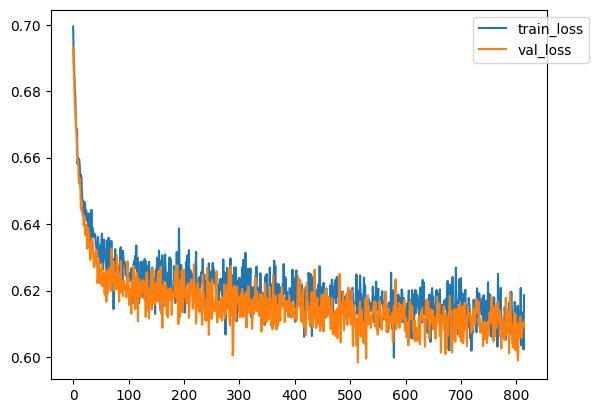

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 0.0894 Sum: 0.0894 val:0.0822
there are 138 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=0.870415449142456, val_loss: 1.04499405622482334

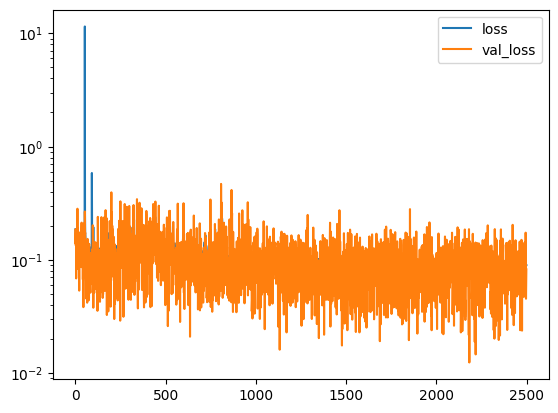

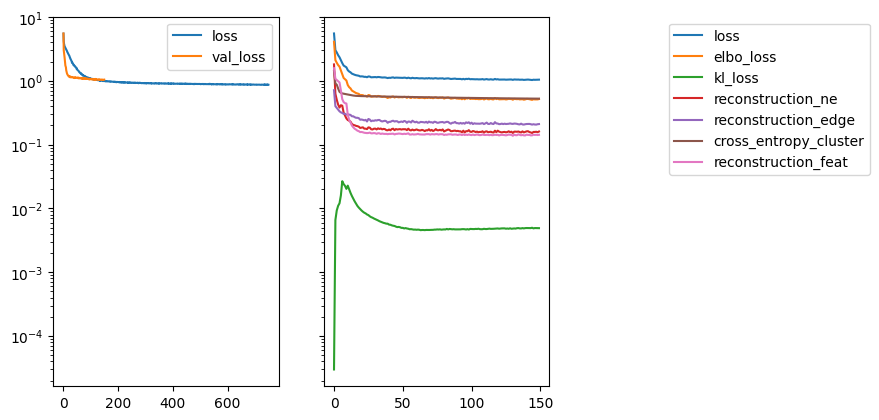

 epoch 775/775 train loss 0.8330 val loss: 0.8841

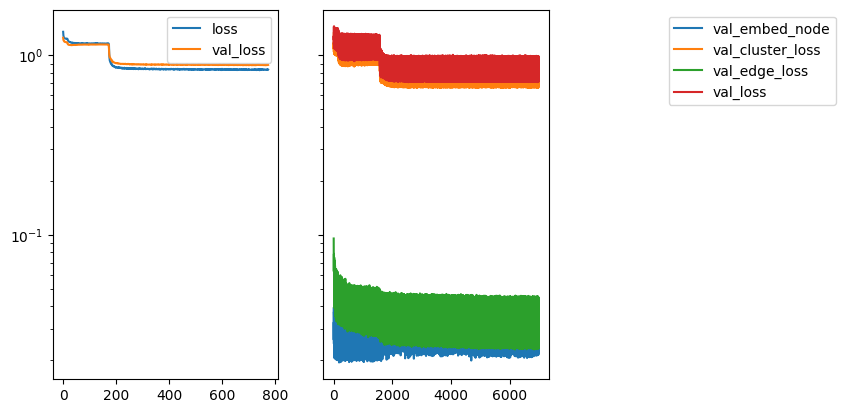

 epoch 375/375 train loss 1.3292 val loss: 1.1966start processing run 6
Epoch: 1256, Loss: 0.5956,  Test: 0.5908Early stopping after 1257 epochs with no improvement in validation loss.
Total training time 151.8884s


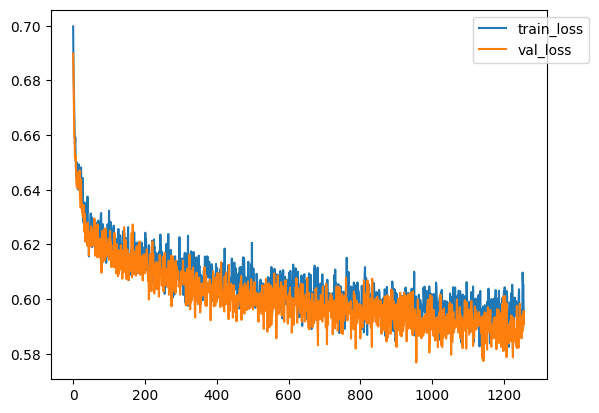

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 0.1021 Sum: 0.1021 val:0.0870
there are 150 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=0.8518334627151489, val_loss: 0.9375429749488831

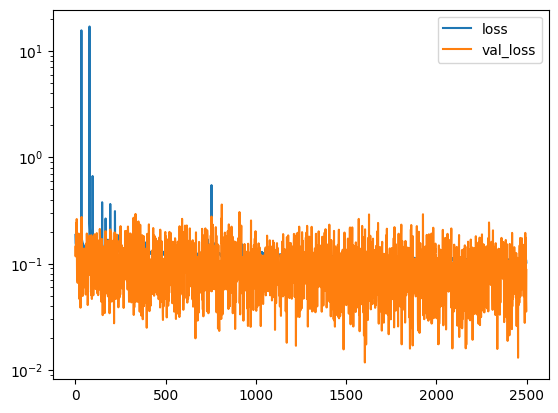

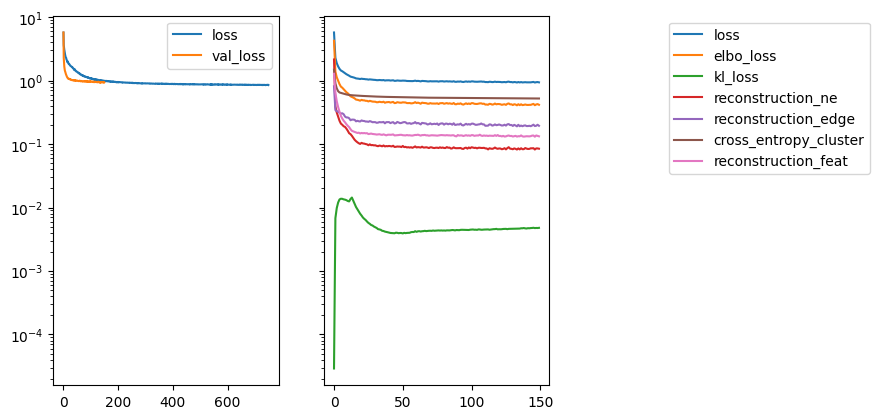

 epoch 775/775 train loss 1.4220 val loss: 1.6309

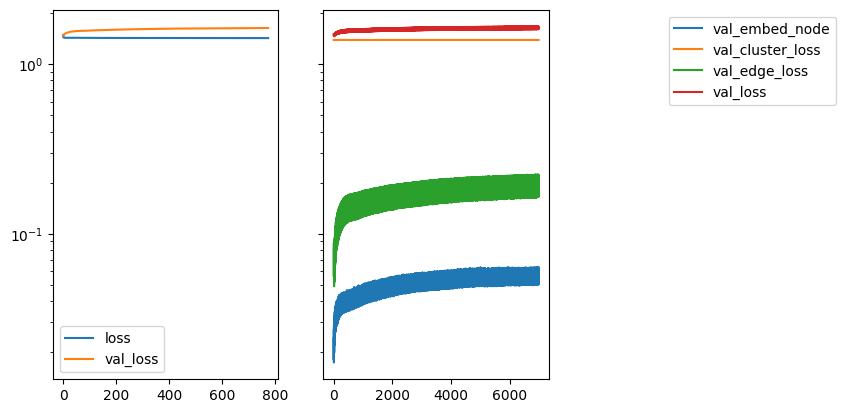

 epoch 375/375 train loss 1.2239 val loss: 1.1092start processing run 7
Epoch: 2111, Loss: 0.5913,  Test: 0.5845Early stopping after 2112 epochs with no improvement in validation loss.
Total training time 248.0678s


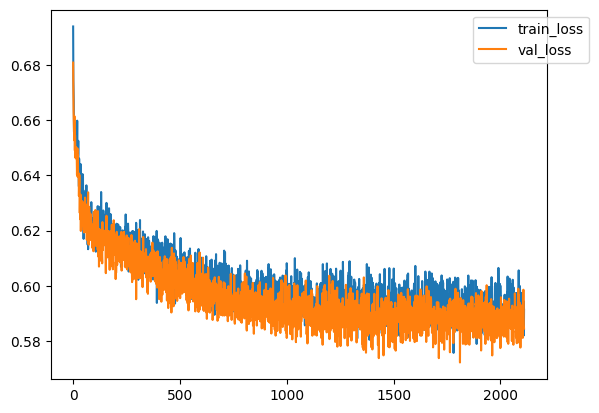

Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 324 out of 300 = 108.0oss: 0.0977 Sum: 0.0977 val:0.0512
there are 150 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=0.9181976318359375, val_loss: 1.0181539058685303

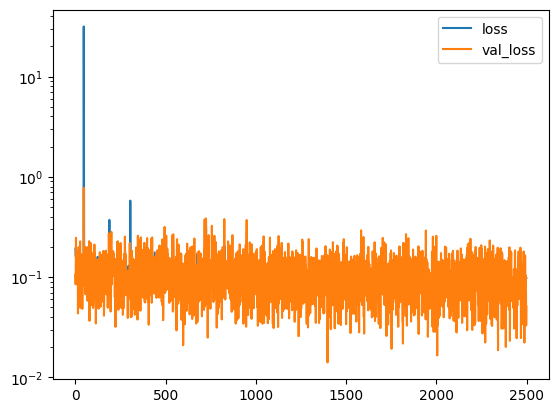

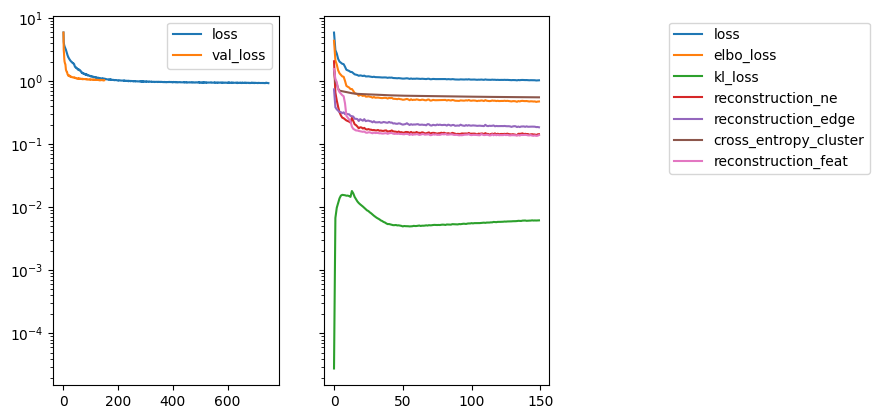

 epoch 775/775 train loss 0.7136 val loss: 0.7752

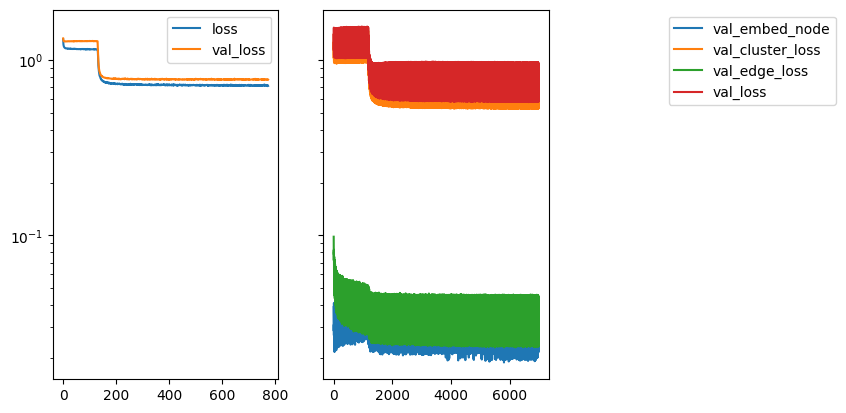

 epoch 375/375 train loss 1.3016 val loss: 1.1618start processing run 8
Epoch: 2214, Loss: 0.6068,  Test: 0.5950Early stopping after 2215 epochs with no improvement in validation loss.
Total training time 278.0873s


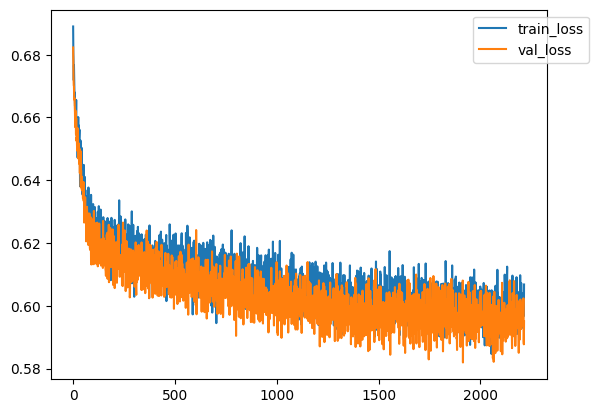

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 1.0034 Sum: 1.0034 val:0.7656139
there are 0 nodes sampled
Epoch: 000, Loss: 0.6945,  Test: 0.6814

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Epoch: 1091, Loss: 0.6034,  Test: 0.5870Early stopping after 1092 epochs with no improvement in validation loss.
Total training time 130.0047s


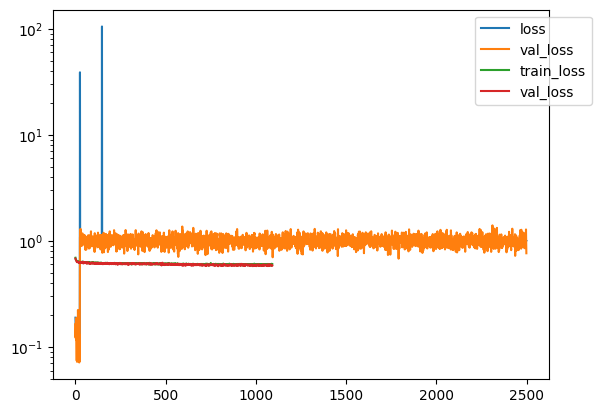

Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03, 'd_in': 128, 'd_out': 13}, 'd_in': 13, 'num_classes': 13}


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


 Generated 324 out of 300 = 108.0oss: 0.0864 Sum: 0.0864 val:0.0989
there are 150 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=0.8980918526649475, val_loss: 0.9779712557792664

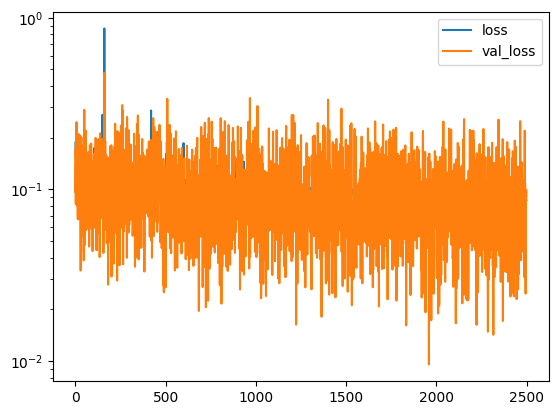

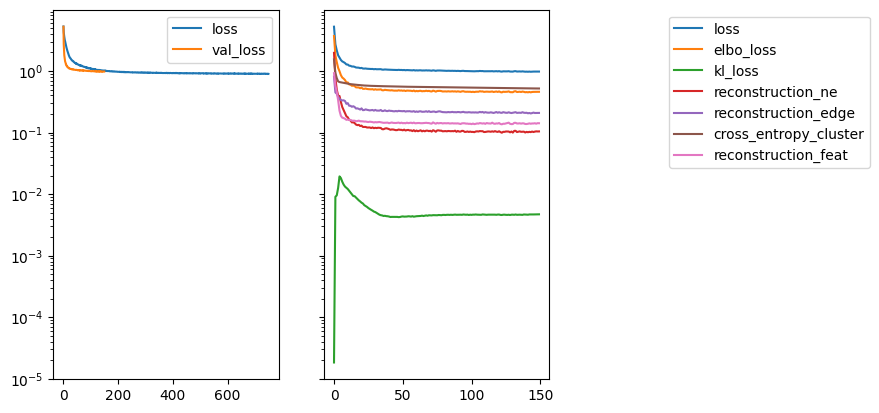

 epoch 775/775 train loss 0.9792 val loss: 1.0326

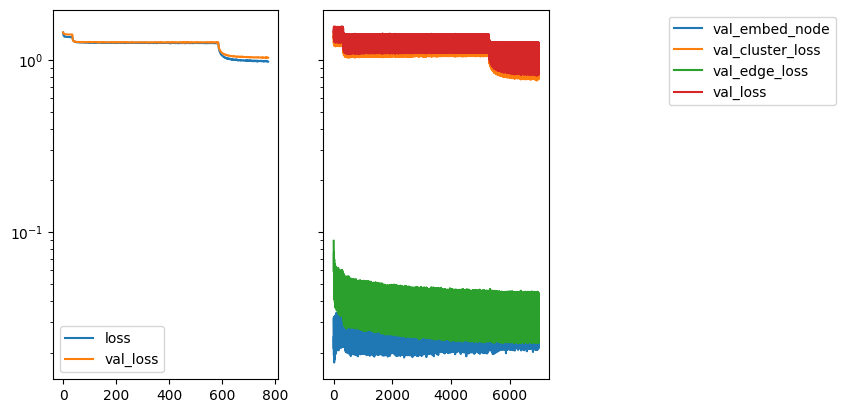

 epoch 375/375 train loss 1.2933 val loss: 1.1847start processing run 9
Epoch: 1728, Loss: 0.5903,  Test: 0.5810Early stopping after 1729 epochs with no improvement in validation loss.
Total training time 217.6129s


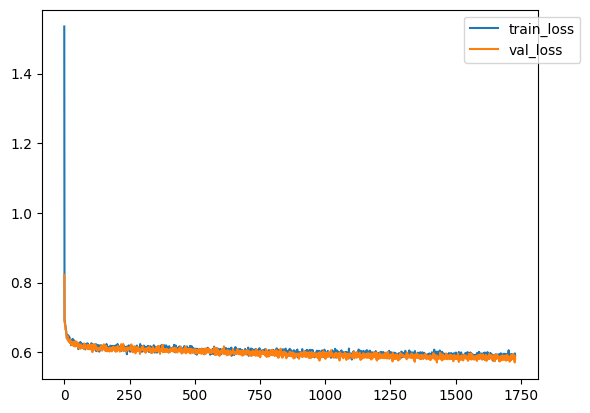

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 0.9994 Sum: 0.9994 val:0.772286
there are 0 nodes sampled
Epoch: 000, Loss: 0.6972,  Test: 0.6894

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Epoch: 1782, Loss: 0.5802,  Test: 0.5919Early stopping after 1783 epochs with no improvement in validation loss.
Total training time 234.2561s


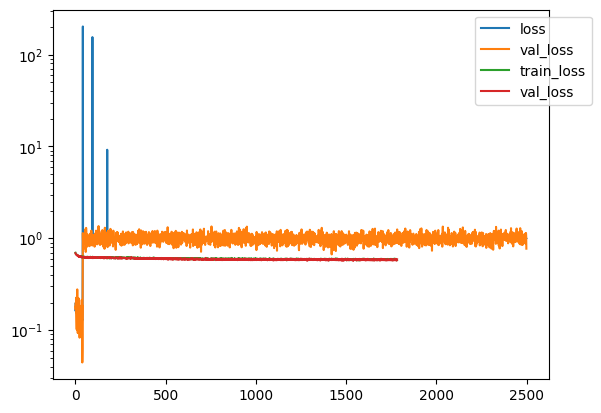

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03, 'd_in': 128, 'd_out': 13}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 0.1162 Sum: 0.1162 val:0.04888478
there are 144 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=0.9376142024993896, val_loss: 0.9643982946872711

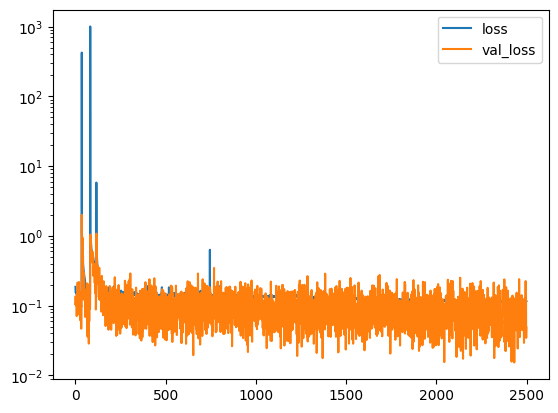

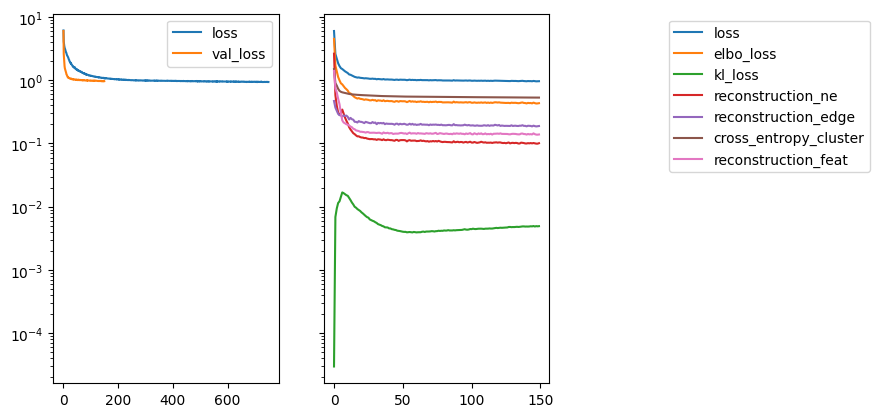

 epoch 775/775 train loss 1.0930 val loss: 1.1228

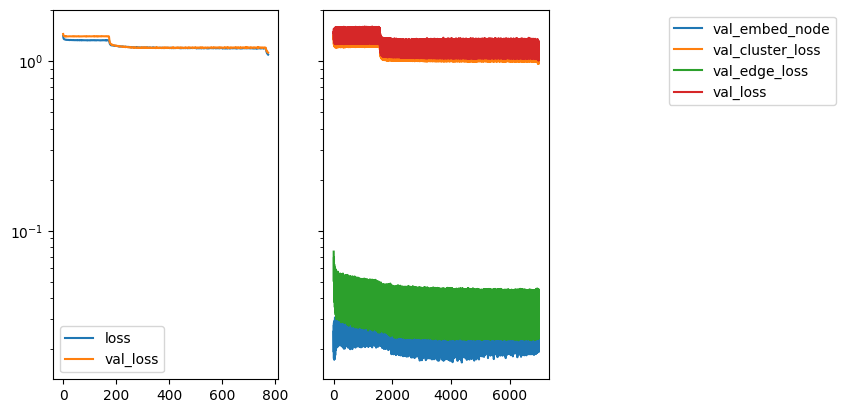

 epoch 375/375 train loss 1.5635 val loss: 1.4354start processing run 10
Epoch: 1316, Loss: 0.5924,  Test: 0.6001Early stopping after 1317 epochs with no improvement in validation loss.
Total training time 161.3706s


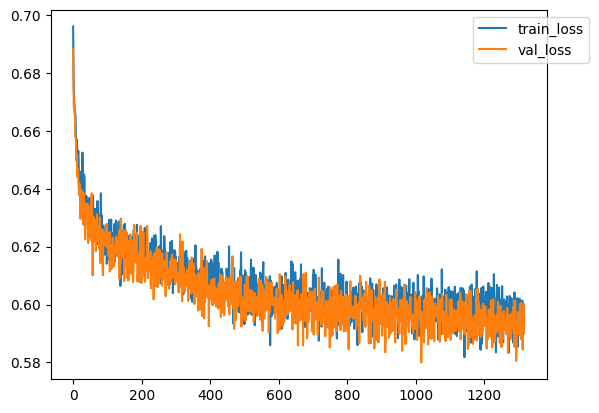

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Category dims K: 0
Total number of dim in: 13
{'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.03}, 'd_in': 13, 'num_classes': 13}
 Generated 324 out of 300 = 108.0oss: 0.1134 Sum: 0.1134 val:0.043240
there are 150 nodes sampled


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/inductive_controller.py:225: UserWarning: feat df has 150 rows and vocab has 151 instead of 152. This can be cause by unconnected nodes.
  warnings.warn(f"feat df has {nodes.shape[0]} rows and vocab has {node_attr.shape[0]} instead of {nodes.shape[0] + 2}. This can be cause by unconnected nodes.")
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/2689 [00:00<?, ?it/s]

Number of components, 5


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 7950 / 8000, epoch:749 loss=0.8617844581604004, val_loss: 0.9437974691390991

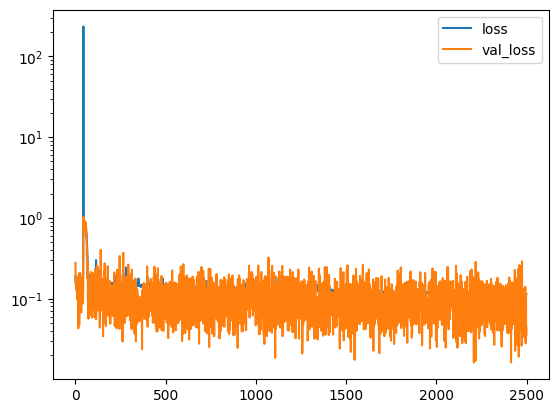

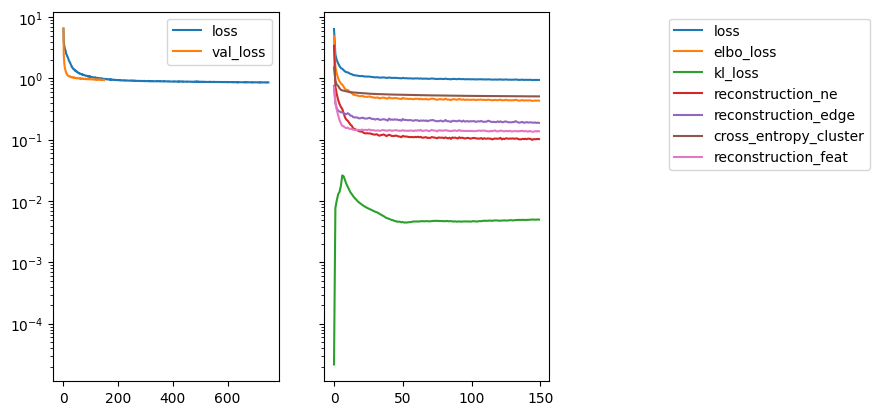

 epoch 775/775 train loss 0.7255 val loss: 0.8312

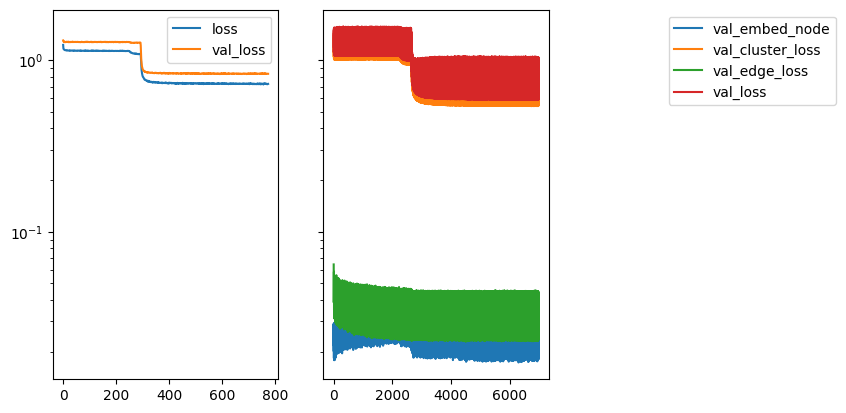

 epoch 375/375 train loss 1.3144 val loss: 1.1817

In [4]:
#dataset folder and load orchestrator
folder = "data/enron/"
res = run_experiment(folder, 8)


In [5]:
_, res = init_res_dataset(folder)
res = res[0]
calculate_Stats(res[res['run_id']!=0])

,run_id,LSTM,MLP,Bi-MLP
type,,,,
Delta_edge_count,5.5,-1971.500000,-1904.700000,-1404.400000
dif_cluster_coef,5.5,0.283033,0.311139,0.307681
edge_attributes,5.5,0.102610,0.120324,0.124587
mean_delta_widget,5.5,0.119216,0.137549,0.067745
node_attributes,5.5,0.019775,0.019775,0.019775


In [7]:
_, res = init_res_dataset(folder)
res = res[0]
calculate_Stats(res[res['run_id']!=0])

,run_id,LSTM,MLP,Bi-MLP
type,,,,
Delta_edge_count,1.5,-2027.000000,-1876.500000,-1233.500000
dif_cluster_coef,1.5,0.275896,0.308784,0.294575
edge_attributes,1.5,0.102685,0.121836,0.124003
mean_delta_widget,1.5,0.114721,0.136687,0.060448
node_attributes,1.5,0.017779,0.017779,0.017779
